In [2]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Step 1: Load the datasets
# Load the customer and transaction data into DataFrames.
customers = pd.read_csv("/Users/abhay/Desktop/Zeotap/Customers.csv")  
transactions = pd.read_csv("/Users/abhay/Desktop/Zeotap/Transactions.csv")

In [6]:
customers.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [7]:
transactions.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [11]:
# Step 2: Merging the datasets
# Merge Transactions.csv with Customers.csv to make transaction data more informative with customer profile information
merged_data = transactions.merge(customers, on='CustomerID', how='left')
merged_data.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,Timothy Perez,Europe,2022-03-15


In [12]:
# Step 3: Feature Engineering (Dimaag Ghoomega)
# Sbse phle calculate metrics like total spending, average transaction value, and purchase frequency for each customer.
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean'],
    'TransactionID': 'count'
}).reset_index()

# Flatten krle column names
customer_features.columns = ['CustomerID', 'TotalSpending', 'AvgTransactionValue', 'PurchaseFrequency']

# Add region to customer features for segmentation purposes
customer_features = customer_features.merge(customers[['CustomerID', 'Region']], on='CustomerID', how='left')

# Encode categorical variables (e.g., Region) to numerical values
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


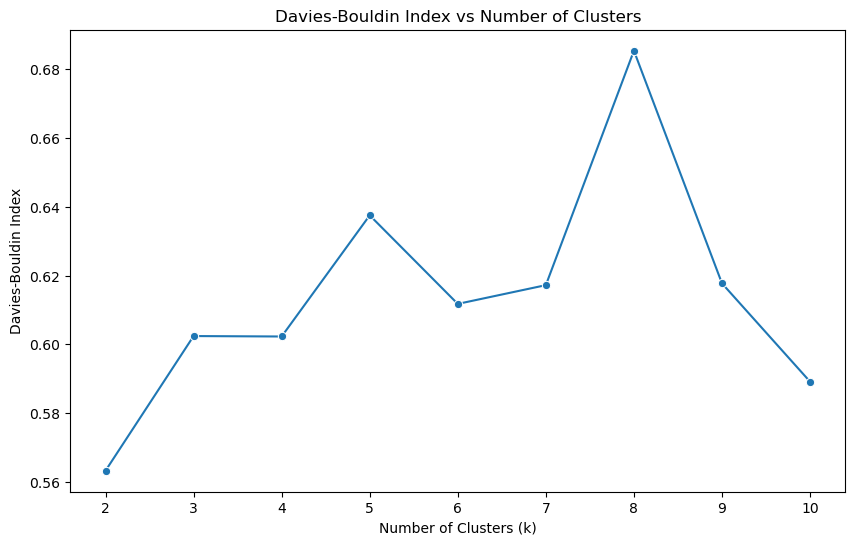

In [14]:
# Step 5: Clustering 
# (You are the average of the five people you spend the most time with.  by - Jim Ron) 
# Experiment with different numbers of clusters (2 to 10) and calculate the Davies-Bouldin Index for each.
db_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(customer_features.drop(columns=['CustomerID']))
    db_index = davies_bouldin_score(customer_features.drop(columns=['CustomerID']), clusters)
    db_scores.append(db_index)

# Plot Davies-Bouldin Index for each k
plt.figure(figsize=(10, 6))
sns.lineplot(x=k_values, y=db_scores, marker='o')
plt.title('Davies-Bouldin Index vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.show()

# Choose the optimal number of clusters (minimum DB Index)
optimal_k = k_values[db_scores.index(min(db_scores))]
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_features['Cluster'] = kmeans.fit_predict(customer_features.drop(columns=['CustomerID']))

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

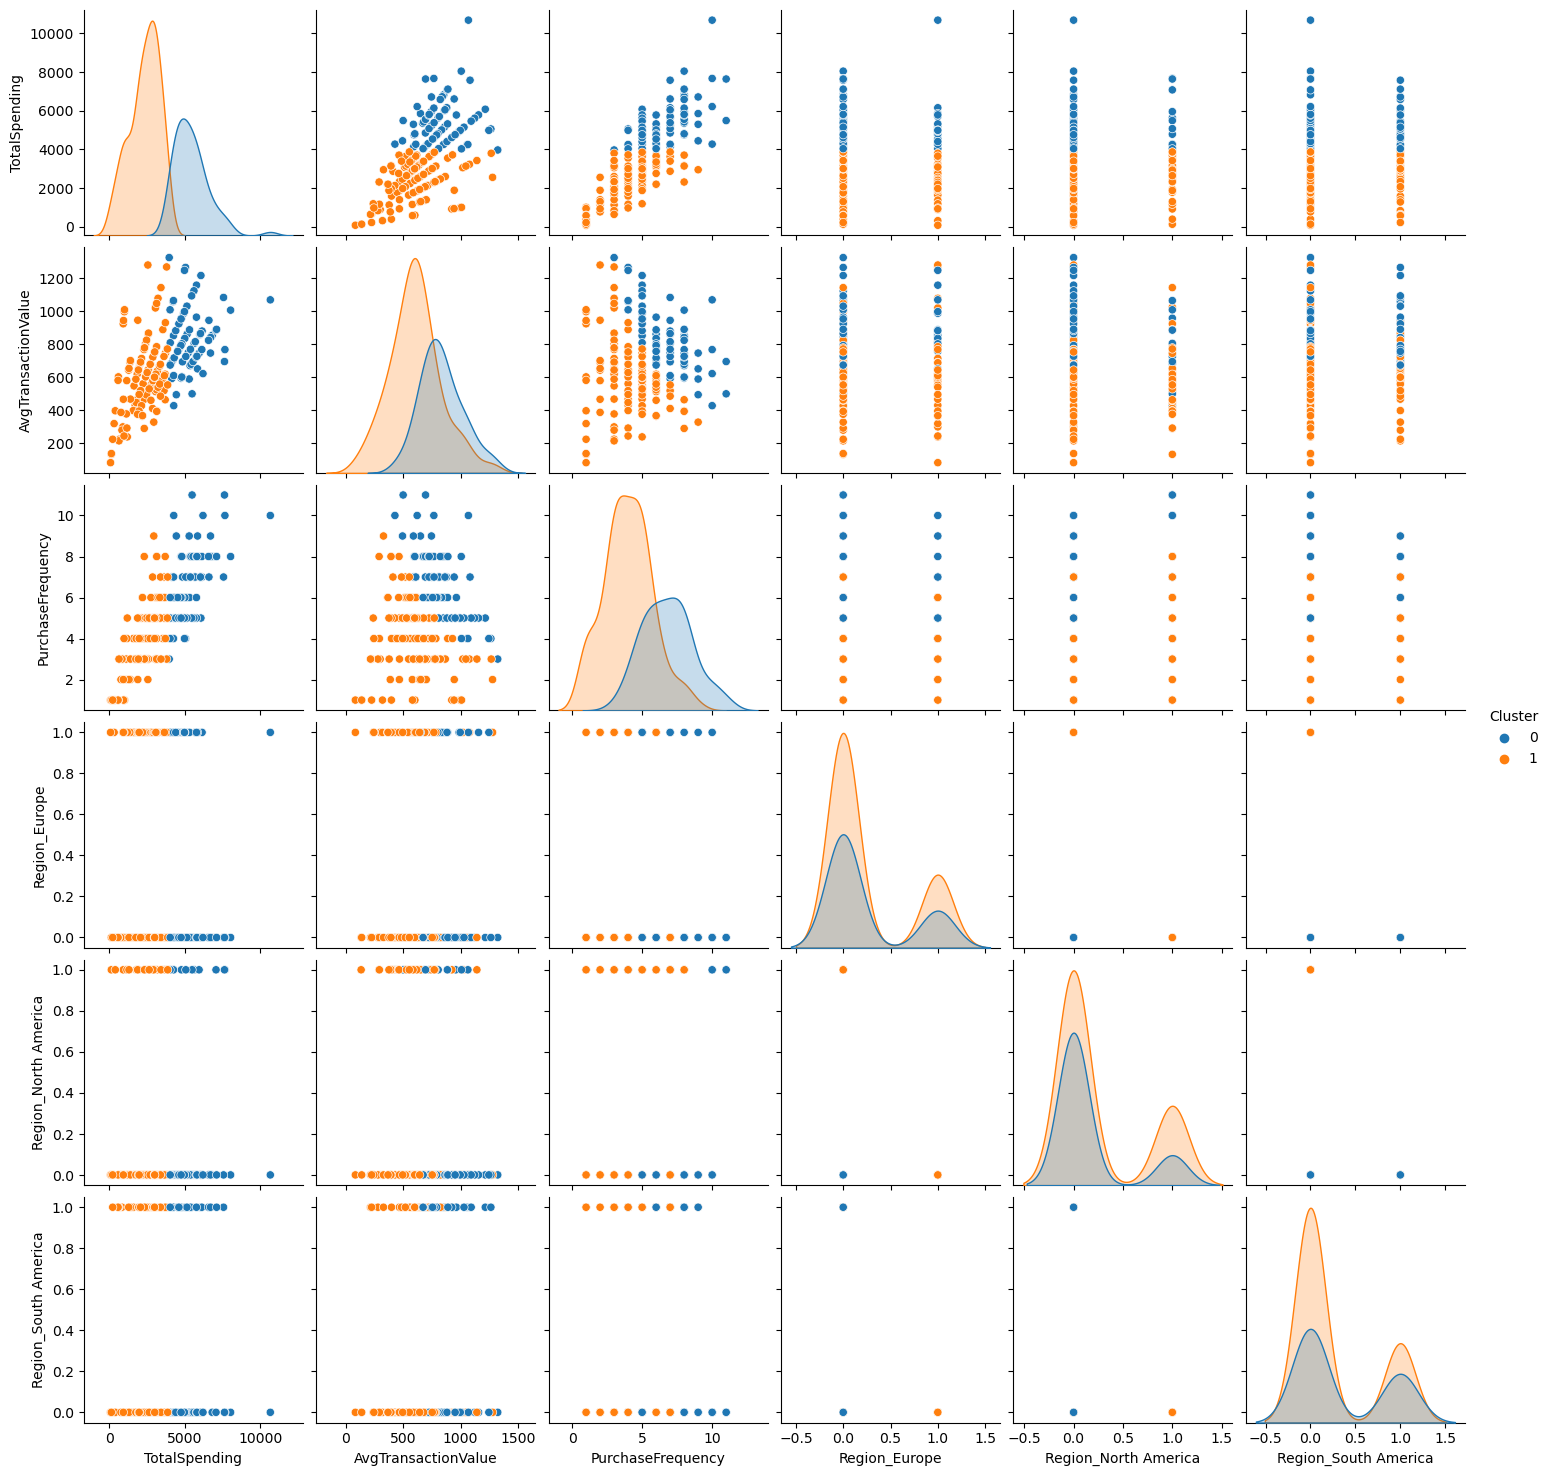

In [15]:
# Step 6: Visualise Clusters
# Use pairplots to visualize clusters in the feature space.
sns.pairplot(customer_features, hue='Cluster', palette='tab10', diag_kind='kde')
plt.show()

In [18]:
# Summarize cluster characteristics
# Only include numerical columns for aggregation
numeric_cols = customer_features.select_dtypes(include=['float64', 'int64']).columns
cluster_summary = customer_features.groupby('Cluster')[numeric_cols].mean()
print("Cluster Summary:\n", cluster_summary)

# Distribution of customers across clusters
print("Customer Distribution:\n", customer_features['Cluster'].value_counts())

Cluster Summary:
          TotalSpending  AvgTransactionValue  PurchaseFrequency
Cluster                                                       
0          5434.096986           832.335486           6.794521
1          2327.829206           603.714014           4.000000
Customer Distribution:
 Cluster
1    126
0     73
Name: count, dtype: int64


In [16]:
# Step 7: Save the clustering results to a CSV file.
customer_features.to_csv('Customer_Clusters.csv', index=False)

print(f"Clustering completed. Optimal number of clusters: {optimal_k}")
print("Results saved to 'Customer_Clusters.csv'")

Clustering completed. Optimal number of clusters: 2
Results saved to 'Customer_Clusters.csv'


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


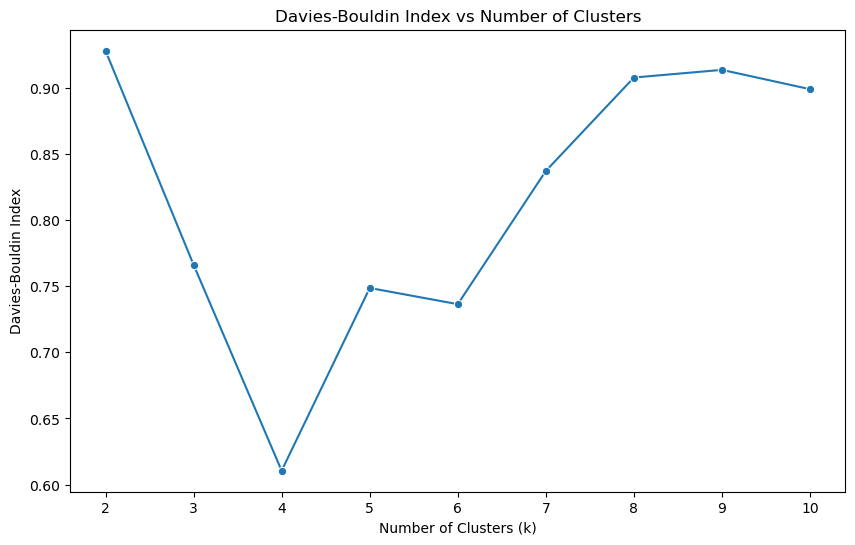

Optimal number of clusters: 4
Inertia: 22.527815985312436
Silhouette Score: 0.7431342549064911


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

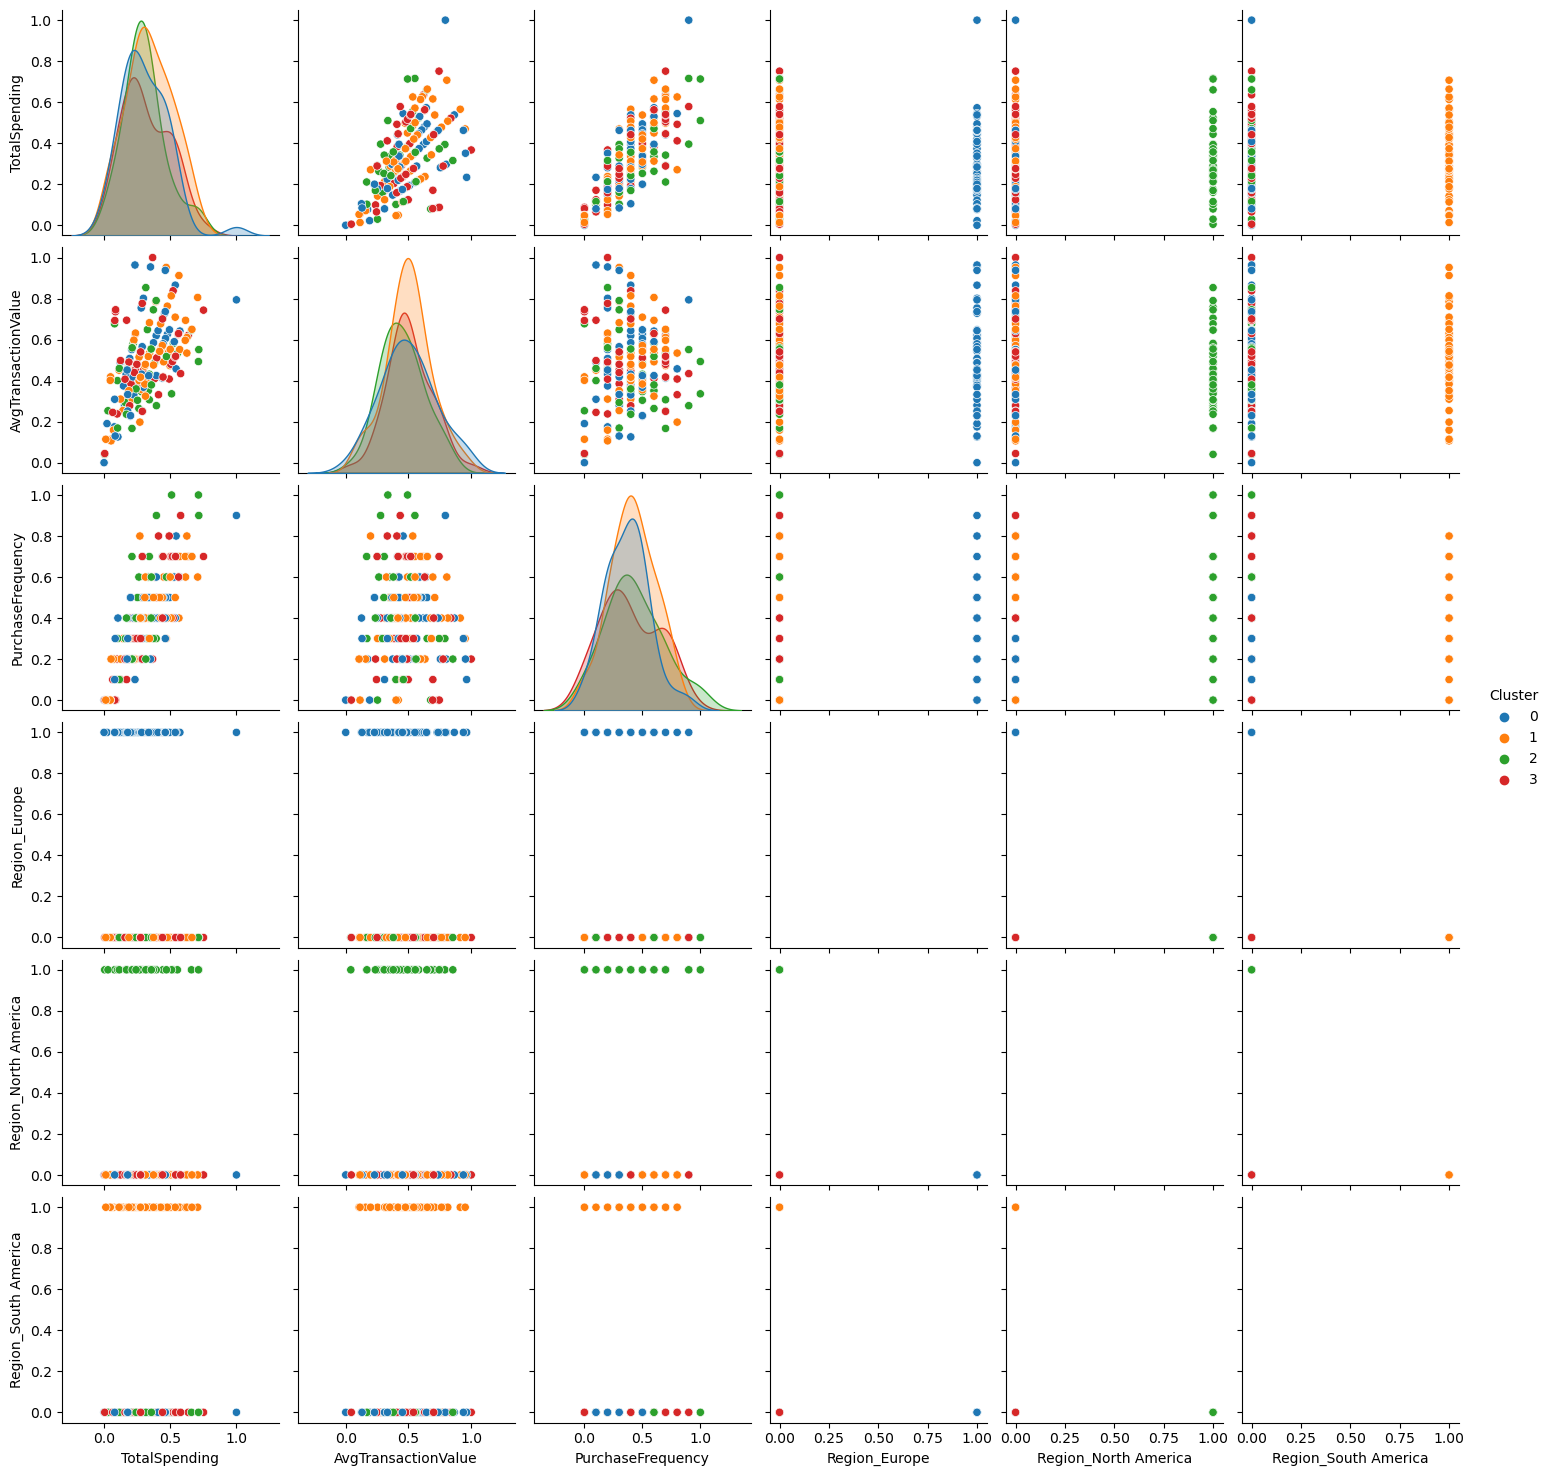

Clustering completed. Optimal number of clusters: 4
Results saved to 'Customer_Clusters.csv'


In [1]:
# Importing Required Libraries
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load the datasets
customers = pd.read_csv("/Users/abhay/Desktop/Zeotap/Customers.csv")  
transactions = pd.read_csv("/Users/abhay/Desktop/Zeotap/Transactions.csv")

# Step 2: Merge the datasets
merged_data = transactions.merge(customers, on='CustomerID', how='left')

# Step 3: Feature Engineering
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalValue': ['sum', 'mean'],
    'TransactionID': 'count'
}).reset_index()

customer_features.columns = ['CustomerID', 'TotalSpending', 'AvgTransactionValue', 'PurchaseFrequency']
customer_features = customer_features.merge(customers[['CustomerID', 'Region']], on='CustomerID', how='left')
customer_features = pd.get_dummies(customer_features, columns=['Region'], drop_first=True)

# Step 4: Normalize features
scaler = MinMaxScaler()
numerical_cols = ['TotalSpending', 'AvgTransactionValue', 'PurchaseFrequency']
customer_features[numerical_cols] = scaler.fit_transform(customer_features[numerical_cols])

# Step 5: Clustering & DB Index Calculation
db_scores = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(customer_features.drop(columns=['CustomerID']))
    db_index = davies_bouldin_score(customer_features.drop(columns=['CustomerID']), clusters)
    db_scores.append(db_index)

# Plot DB Index
plt.figure(figsize=(10, 6))
sns.lineplot(x=k_values, y=db_scores, marker='o')
plt.title('Davies-Bouldin Index vs Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.show()

# Optimal Number of Clusters
optimal_k = k_values[db_scores.index(min(db_scores))]
print(f"Optimal number of clusters: {optimal_k}")

# Step 6: Calculate Inertia and Silhouette Score
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42)
customer_features['Cluster'] = kmeans_final.fit_predict(customer_features.drop(columns=['CustomerID']))

inertia = kmeans_final.inertia_
silhouette_avg = silhouette_score(customer_features.drop(columns=['CustomerID']), customer_features['Cluster'])

print(f"Inertia: {inertia}")
print(f"Silhouette Score: {silhouette_avg}")

# Step 7: Visualize Clusters
sns.pairplot(customer_features, hue='Cluster', palette='tab10', diag_kind='kde')
plt.show()

# Step 8: Save Clustering Results
customer_features.to_csv('Customer_Clusters.csv', index=False)

# Report Summary
print(f"Clustering completed. Optimal number of clusters: {optimal_k}")
print("Results saved to 'Customer_Clusters.csv'")

In [5]:
from sklearn.metrics import davies_bouldin_score

# Calculate DB Index for k = 2 to k = 10 and store in list
db_scores = [
    davies_bouldin_score(customer_features.drop(columns=['CustomerID']),
                         KMeans(n_clusters=k, random_state=42).fit_predict(customer_features.drop(columns=['CustomerID'])))
    for k in range(2, 11)
]

# Davies-Bouldin Index for k = 4 (stored at index 2 in the list)
db_index_k4 = db_scores[2]

# Print all DB Index values
for k, db_index in zip(range(2, 11), db_scores):
    print(f"k = {k}: {db_index}")

# Print DB Index for k = 4
print(f"\nDavies-Bouldin Index for k = 4: {db_index_k4}")

k = 2: 0.6354909354040157
k = 3: 0.5114035545879337
k = 4: 0.383335553763368
k = 5: 0.5975530222554692
k = 6: 0.7689516196243492
k = 7: 0.8125411810918939
k = 8: 0.8304804040596455
k = 9: 0.9197523423375569
k = 10: 0.9181335680232723

Davies-Bouldin Index for k = 4: 0.383335553763368


In [8]:
from sklearn.metrics import silhouette_score

# Perform clustering with the optimal k (4 in this case)
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(customer_features.drop(columns=['CustomerID']))

# Add the cluster labels to the DataFrame
customer_features['Cluster'] = clusters

# Calculate Inertia
inertia = kmeans.inertia_

# Calculate Silhouette Score
silhouette_avg = silhouette_score(customer_features.drop(columns=['CustomerID', 'Cluster']), clusters)

# Print the results
print(f"Inertia (Sum of Squared Distances to Centroids): {inertia}")
print(f"Silhouette Score: {silhouette_avg}")

Inertia (Sum of Squared Distances to Centroids): 22.527815985312436
Silhouette Score: 0.6205322658864421
